## 📊 Application of Machine Learning Methods

In this study, various supervised machine learning algorithms were applied to explore the relationship between environmental pollution indicators and cardiovascular disease outcomes. After preparing and merging datasets from pollution records and heart disease statistics, several classification and regression models were implemented to assess the predictive power of environmental factors on heart health.

The following machine learning methods were employed:

- **Simple and Multiple Linear Regression**  
  Used to model continuous outcomes such as the *Heart Disease Index*, allowing us to examine how pollution variables linearly relate to cardiovascular risks.

- **K-Nearest Neighbors (KNN)**  
  Applied for categorical prediction of heart disease risk classes (e.g., *Low* vs *High*). This instance-based algorithm enables analysis of how neighboring states with similar pollution profiles correspond to health outcomes.

- **Decision Tree & Random Forest**  
  A basic **Decision Tree** was first utilized to provide interpretable logic-based predictions. Then, **Random Forest**, an ensemble technique, was employed to improve prediction accuracy and evaluate feature importance.

- **Extreme Gradient Boosting (XGBoost)**  
  Implemented to enhance classification performance using boosting techniques. XGBoost allowed us to capture complex nonlinear patterns between pollutants and heart disease labels.

> The goal of applying these models is to determine whether environmental pollutants can meaningfully predict heart disease occurrence or severity, and to compare the effectiveness of each ML method in doing so.

Each method was applied appropriately depending on the target variable (continuous or categorical), and evaluation metrics such as **RMSE**, **accuracy**, **confusion matrix**, and **ROC-AUC** were used to assess model performance.


## 🔧 From Phase II: Data Preparation for Machine Learning

This section prepares pollution and heart disease data for modeling by cleaning, aggregating, normalizing, and merging datasets.

### 🏭 1. Pollution Data Preprocessing
- The pollution dataset is first filtered to include only records from **2004 to 2013**, which ensures temporal alignment with heart disease data.
- Relevant pollution variables (`O₃ Mean`, `CO Mean`, `SO₂ Mean`, `NO₂ Mean`) are converted to numeric to avoid parsing issues.
- The mean pollutant levels are calculated **per state** using `groupby()`.

### ⚖️ 2. Z-Score Normalization
- Each pollutant is standardized using **Z-score normalization**, which centers the data around a mean of 0 and scales it by standard deviation.
- This ensures that all pollutant indicators are on a comparable scale, preventing variables with larger numeric ranges from dominating.

### 🧮 3. Pollution Index Calculation
- A **composite Pollution Index** is created by assigning weights to each normalized pollutant:
  - NO₂: 0.35  
  - SO₂: 0.30  
  - CO : 0.20  
  - O₃ : 0.15  
- These weights reflect the relative importance or impact of each pollutant on human health.

### ❤️ 4. Heart Disease Data Processing
- The heart disease dataset is filtered to include only **state-level**, **overall** records for **Heart Failure** and **Coronary Heart Disease**.
- A new variable, `Heart Disease Index`, is computed as the average of these two conditions.

### 🔗 5. Merging Datasets
- The final step merges the pollution and heart disease datasets **by state**, yielding a unified `merged_df` DataFrame that contains:
  - Z-score normalized pollution indicators
  - A calculated Pollution Index
  - Heart disease metrics

This merged dataset is now ready to be used in machine learning algorithms to explore the potential relationship between environmental pollution and cardiovascular health outcomes.



In [ ]:
import pandas as pd

df = pd.read_csv("pollution_2000_2023.csv")

df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year

filtered_df = df[(df['Year'] >= 2004) & (df['Year'] <= 2013)].copy()

for col in ['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']:
    filtered_df.loc[:, col] = pd.to_numeric(filtered_df[col], errors='coerce')

state_means = filtered_df.groupby('State')[['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']].mean().reset_index()

state_means.head()

for col in ['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean']:
    mean_val = state_means[col].mean()
    std_val = state_means[col].std()
    state_means[f'{col}_norm'] = (state_means[col] - mean_val) / std_val

w_NO2 = 0.35
w_SO2 = 0.30
w_CO  = 0.20
w_O3  = 0.15

state_means['Pollution Index'] = (
    w_NO2 * state_means['NO2 Mean_norm'] +
    w_SO2 * state_means['SO2 Mean_norm'] +
    w_CO  * state_means['CO Mean_norm'] +
    w_O3  * state_means['O3 Mean_norm']
)
state_means.head()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

heart_df = pd.read_csv("heart_disease_data.csv")

heart_df_cleaned = heart_df[
    (heart_df['LocationDesc'] != 'United States') &
    (heart_df['Break_Out'] == 'Overall') &
    (heart_df['Topic'].isin(['Heart Failure', 'Coronary Heart Disease']))
][['Year', 'LocationDesc', 'Topic', 'Data_Value']]

heart_pivot = heart_df_cleaned.pivot_table(
    index=['LocationDesc', 'Year'],
    columns='Topic',
    values='Data_Value'
).reset_index()

heart_pivot['Heart Disease Index'] = 0.5 * heart_pivot['Heart Failure'] + 0.5 * heart_pivot['Coronary Heart Disease']

heart_state_avg = heart_pivot.groupby('LocationDesc')[['Heart Disease Index', 'Heart Failure', 'Coronary Heart Disease']].mean().reset_index()
heart_state_avg.rename(columns={'LocationDesc': 'State'}, inplace=True)

merged_df = pd.merge(state_means, heart_state_avg, on='State', how='inner')
merged_df = merged_df.drop(columns=['O3 Mean', 'CO Mean', 'SO2 Mean', 'NO2 Mean'])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
merged_df.columns = merged_df.columns.str.replace(' ', '_')
merged_df.head(10)

,State,O3_Mean_norm,CO_Mean_norm,SO2_Mean_norm,NO2_Mean_norm,Pollution_Index,Heart_Disease_Index,Heart_Failure,Coronary_Heart_Disease
0,Alabama,-2.990058,-0.838830,-0.743610,0.237961,-0.756071,14.904,23.328,6.48
1,Arizona,-0.085155,1.192156,-0.245662,1.628775,0.722030,10.919,14.998,6.84
2,Arkansas,0.048871,1.138257,-0.119827,-0.208767,0.125965,14.907,22.174,7.64
3,California,-0.042206,0.766751,-0.473340,0.428940,0.155146,11.410,16.910,5.91
4,Colorado,-0.381673,1.154873,-0.025720,1.919110,0.837696,9.244,13.528,4.96
5,Connecticut,0.380504,-0.399287,-0.487932,-0.343711,-0.289460,13.366,21.022,5.71
6,Delaware,0.067367,-0.492005,-0.463577,0.124018,-0.183963,13.092,19.924,6.26
7,Florida,0.360262,0.448717,-1.104645,-0.999834,-0.537553,13.703,20.766,6.64
8,Georgia,-0.866602,0.119611,-0.886704,0.200689,-0.301838,13.793,20.726,6.86
9,Hawaii,-0.365833,0.423653,-0.573125,-1.754345,-0.756103,10.168,13.306,7.03


In [ ]:
# Summary statistics

merged_df.describe()

,O3_Mean_norm,CO_Mean_norm,SO2_Mean_norm,NO2_Mean_norm,Pollution_Index,Heart_Disease_Index,Heart_Failure,Coronary_Heart_Disease
count,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000,44.000000
mean,0.004262,-0.090059,-0.042249,-0.027976,-0.039839,12.797432,19.048273,6.546591
std,1.011148,0.806095,0.970083,0.993588,0.618481,2.284838,4.637064,0.627927
min,-2.990058,-1.655192,-1.204011,-2.201128,-1.094909,8.589000,10.368000,4.960000
25%,-0.417802,-0.760821,-0.822363,-0.795906,-0.652253,10.911250,14.833500,6.197500
50%,0.058119,0.113307,-0.459932,0.145398,0.016301,13.219500,19.922000,6.530000
75%,0.484590,0.429919,0.580370,0.540735,0.546449,14.414000,22.743500,6.845000
max,2.434623,1.475691,2.359074,1.919110,1.109864,16.795000,27.040000,8.110000


## 📈 Linear Regression with Pollution Index

In this section, a **simple linear regression model** is constructed to investigate the relationship between environmental pollution and heart disease.

### 🔍 Purpose:
The goal is to evaluate whether the **Pollution Index**, which aggregates multiple air quality indicators (NO₂, SO₂, CO, O₃), can effectively predict the **Heart Disease Index**, which reflects the average incidence of heart failure and coronary heart disease.

### ⚙️ What the code does:
- A `LinearRegression` model from `sklearn` is created.
- The **Pollution Index** is used as the independent variable (X).
- The **Heart Disease Index** is the dependent variable (y).
- The model is trained using the `merged_df` dataset.
- After training, it prints:
  - **Intercept**
  - **Coefficient**
  
This model helps quantify the linear effect of pollution on cardiovascular health at the state level.


In [ ]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

predictors_pollution = ['Pollution_Index']
outcome_health = 'Heart_Disease_Index'

model_pollution = LinearRegression()
model_pollution.fit(merged_df[predictors_pollution], merged_df[outcome_health])

print(f'Intercept: {model_pollution.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors_pollution, model_pollution.coef_):
    print(f'{name}: {coef:.3f}')


Intercept: 12.828
Coefficients:
Pollution_Index: 0.774


## 📉 Linear Regression: Prediction & Visualization

After training the linear regression model, we now:

### 🔢 1. Estimate Heart Disease Index at Minimum Pollution
- Using the **minimum Pollution Index value**, we predict the corresponding Heart Disease Index.
- This helps us understand the baseline level of cardiovascular risk in the **least polluted** states.

### 📊 2. Visualize the Regression Fit
- A **scatter plot** shows the actual data points (`Pollution Index` vs `Heart Disease Index`).
- A **regression line** is drawn to represent the model’s predicted values.
- This allows us to visually assess the trend and strength of the linear relationship.

This plot is essential for identifying whether a linear association exists between air pollution and heart disease prevalence at the state level.


In [ ]:
predicted_low = model_pollution.coef_[0] * merged_df['Pollution_Index'].min() + model_pollution.intercept_
print(f"Predicted Heart Disease Index (minimum Pollution index): {predicted_low:.2f}")


Predicted Heart Disease Index (minimum Pollution index): 11.98


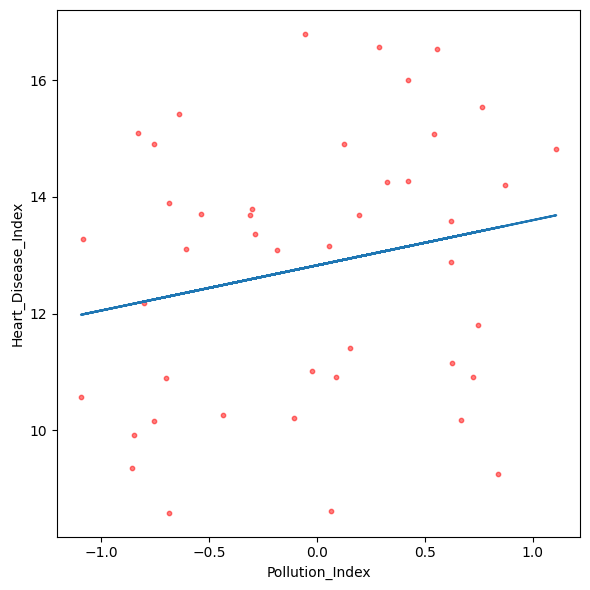

In [ ]:
fitted_values = model_pollution.predict(merged_df[predictors_pollution])
residuals = merged_df[outcome_health] - fitted_values

ax = merged_df.plot.scatter(x='Pollution_Index', y='Heart_Disease_Index', figsize=(6, 6), color='red', alpha=0.5, s=10)
ax.plot(merged_df['Pollution_Index'], fitted_values)
plt.tight_layout()
plt.show()

## 📊 Multiple Linear Regression Analysis

To explore how different air pollutants jointly affect cardiovascular health, we performed **Multiple Linear Regression** using:

- **O₃ Mean (normalized)**
- **CO Mean (normalized)**
- **SO₂ Mean (normalized)**
- **NO₂ Mean (normalized)**
- **Pollution Index**

as predictors, and **Heart Disease Index** as the outcome variable.

---

### 🔹 Scikit-learn Output
We used `LinearRegression` from `sklearn` to estimate the intercept and coefficients. This allowed us to understand the **direction and magnitude** of each pollutant’s contribution to heart disease levels.

- For example:
  - **SO₂** had a strong **positive coefficient**, indicating a potential harmful effect.
  - **CO** and **O₃** had **negative coefficients**, suggesting an inverse relationship.

---

### 🔸 Statsmodels Summary
To gain statistical insight into the regression, we used `statsmodels` to generate a full OLS summary:

- **R-squared**: 0.283 → About 28.3% of the variability in heart disease is explained by the model.
- **p-values** help identify which variables are statistically significant.
- Confidence intervals give us a range of plausible values for each coefficient.

---

This regression analysis helps us interpret the **combined and individual effects** of air pollution indicators on cardiovascular outcomes, supporting our central hypothesis about environmental health risks.


In [ ]:
from sklearn.linear_model import LinearRegression

predictors_health = ['O3_Mean_norm', 'CO_Mean_norm', 'SO2_Mean_norm', 'NO2_Mean_norm', 'Pollution_Index']
outcome_health = 'Heart_Disease_Index'

model_health = LinearRegression()
model_health.fit(merged_df[predictors_health], merged_df[outcome_health])

print(f'Intercept: {model_health.intercept_:.3f}')
print('Coefficients:')
for name, coef in zip(predictors_health, model_health.coef_):
    print(f'{name}: {coef:.3f}')

Intercept: 12.766
Coefficients:
O3_Mean_norm: -0.491
CO_Mean_norm: -0.964
SO2_Mean_norm: 1.312
NO2_Mean_norm: -0.181
Pollution_Index: 0.064


In [ ]:
import statsmodels.formula.api as smf

model_interaction = smf.ols(formula='Heart_Disease_Index ~ O3_Mean_norm + Pollution_Index + CO_Mean_norm + SO2_Mean_norm + NO2_Mean_norm', data=merged_df)
results_interaction = model_interaction.fit()
print(results_interaction.summary())

                             OLS Regression Results                            
Dep. Variable:     Heart_Disease_Index   R-squared:                       0.283
Model:                             OLS   Adj. R-squared:                  0.209
Method:                  Least Squares   F-statistic:                     3.849
Date:                 Tue, 27 May 2025   Prob (F-statistic):            0.00992
Time:                         13:59:31   Log-Likelihood:                -90.965
No. Observations:                   44   AIC:                             191.9
Df Residuals:                       39   BIC:                             200.9
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          12.7657      

## ✅ Cross-Validation and Class Conversion

In this section, we evaluated the **generalizability and performance** of our multiple linear regression model using **5-Fold Cross-Validation**.

---

### 📉 Cross-Validation with RMSE
To estimate how well our model would perform on unseen data, we applied 5-fold cross-validation. For each fold:

- The model was trained on 80% of the data.
- It was tested on the remaining 20%.
- The evaluation metric was **Root Mean Squared Error (RMSE)**.

This provided insight into the **stability** and **variability** of model performance.

Key results:
- **Mean RMSE**: 2.07
- **Standard Deviation**: 0.19
- The RMSE scores indicate how close the predicted heart disease index values are to actual values on average.

In [ ]:
import numpy as np
import statistics
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression

features = ['O3_Mean_norm', 'CO_Mean_norm', 'SO2_Mean_norm', 'NO2_Mean_norm', 'Pollution_Index']
target = 'Heart_Disease_Index'

X = merged_df[features].values
y = merged_df[target].values

model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=42)

neg_mse_scores = cross_val_score(model, X, y, cv=kf, scoring="neg_mean_squared_error")

rmse_scores = np.sqrt(-neg_mse_scores)

print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE:", statistics.mean(rmse_scores))
print("Standard deviation:", statistics.stdev(rmse_scores))

RMSE scores for each fold: [2.27189377 1.87292345 1.86965799 2.25823013 2.07312783]
Mean RMSE: 2.0691666316889252
Standard deviation: 0.19696070374779587


### 🔍 K-Nearest Neighbors (KNN) Classification

In this section, the **K-Nearest Neighbors (KNN)** algorithm is applied to classify the states based on their heart disease risk levels — labeled as **"Low"** or **"High"**. KNN is a **non-parametric and instance-based learning** algorithm that makes predictions by finding the majority class among the 'k' most similar data points (neighbors) in the training set.

Since our dataset is relatively small (only 44 instances representing U.S. states), we adopted the **Leave-One-Out Cross-Validation (LOO-CV)** method, which is particularly suitable for small samples. This method ensures that each observation is used once as a test case while the remaining are used for training, providing a more robust performance estimate.

To determine the most effective K value, a range of K values was tested and evaluated based on classification accuracy. Once the best K was selected, we evaluated the final model using a **confusion matrix** and key performance metrics such as **precision, recall, F1-score, and overall accuracy**.

Through this classification approach, we aim to assess whether the pollution-related variables can meaningfully distinguish between states with low and high heart disease index scores.



In [ ]:
merged_df['Heart_Disease_Class'] = pd.cut(
    merged_df['Heart_Disease_Index'],
    bins=[0, 13, 17],
    labels=['Low', 'High']
)
merged_df['Heart_Disease_Class'].value_counts()

,count
Heart_Disease_Class,
High,25
Low,19


### 🔧 Determining the Optimal K for KNN using Leave-One-Out Cross-Validation

In this part, we aim to determine the **optimal number of neighbors (K)** for the K-Nearest Neighbors (KNN) algorithm by using **Leave-One-Out Cross-Validation (LOO-CV)**. Given the relatively small size of our dataset (44 observations), LOO-CV is a suitable choice because it maximizes training data utilization by leaving one observation out at each iteration for validation.

We looped through various odd K values from 1 to 19 and calculated the **mean classification accuracy** for each using `cross_val_score`. The value of K that yields the highest average accuracy is selected as the optimal K.

The resulting accuracies are then visualized in a **line plot**, making it easier to observe how the model performance changes with different K values.

This process ensures that our final KNN classifier is trained with the best possible K value for our specific dataset, minimizing bias and variance trade-off.


In [ ]:
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt

X = merged_df[features]
y = merged_df['Heart_Disease_Class']

loo = LeaveOneOut()

k_values = list(range(1, 20, 2))
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=loo, scoring='accuracy')
    accuracies.append(np.mean(scores))

best_k = k_values[np.argmax(accuracies)]
print(f"Best K: {best_k}")

Best K: 5


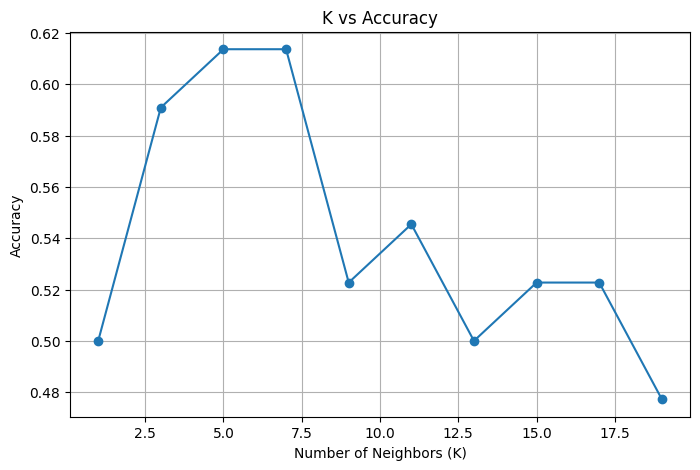

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='o')
plt.title("K vs Accuracy")
plt.xlabel("Number of Neighbors (K)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

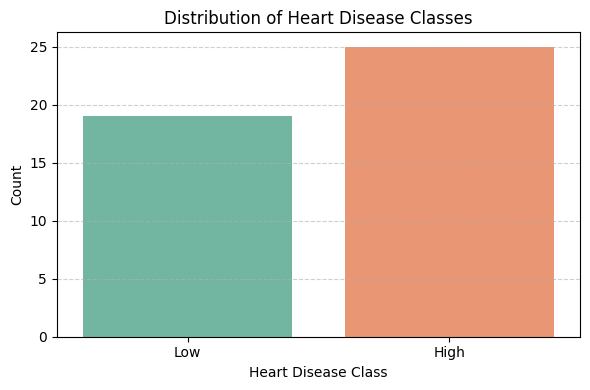

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

sns.countplot(data=merged_df, x='Heart_Disease_Class', hue='Heart_Disease_Class', palette='Set2', legend=False)

plt.title('Distribution of Heart Disease Classes')
plt.xlabel('Heart Disease Class')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### 📊 Confusion Matrix for KNN Classification (k=5)

After determining the optimal number of neighbors (K=5) for the K-Nearest Neighbors classifier, we applied the **Leave-One-Out Cross-Validation (LOO-CV)** strategy to predict the heart disease class ("Low" vs "High") for each observation.

The predicted results were compared to the actual labels, and a **confusion matrix** was generated to visualize the model's performance. This matrix allows us to evaluate how well the model distinguishes between the two classes.

The confusion matrix displays:
- **True Positives (TP)**: Correctly predicted "High" cases.
- **True Negatives (TN)**: Correctly predicted "Low" cases.
- **False Positives (FP)**: "Low" cases incorrectly predicted as "High".
- **False Negatives (FN)**: "High" cases incorrectly predicted as "Low".

This visual summary is an essential diagnostic tool to assess the model’s effectiveness, especially in the presence of class imbalance.


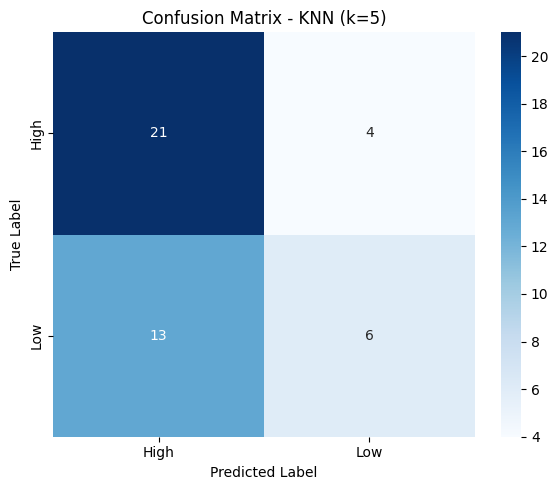

In [ ]:
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

features = ['O3_Mean_norm', 'CO_Mean_norm', 'SO2_Mean_norm', 'NO2_Mean_norm', 'Pollution_Index']
X = merged_df[features]
y = merged_df['Heart_Disease_Class']

knn_final = KNeighborsClassifier(n_neighbors=5)
loo = LeaveOneOut()

y_pred = cross_val_predict(knn_final, X, y, cv=loo)

unique_classes = sorted(y.unique())
cm = confusion_matrix(y, y_pred, labels=unique_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - KNN (k=5)')
plt.tight_layout()
plt.show()

In [ ]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

        High       0.62      0.84      0.71        25
         Low       0.60      0.32      0.41        19

    accuracy                           0.61        44
   macro avg       0.61      0.58      0.56        44
weighted avg       0.61      0.61      0.58        44



### 🔍 ROC Curve and Accuracy for KNN (k=5)

To evaluate the classification performance of the K-Nearest Neighbors (KNN) model, we computed both **accuracy** and the **ROC (Receiver Operating Characteristic) curve**.

In this setup:
- The KNN classifier was trained using an 80/20 train-test split with `k=5`.
- The model’s **accuracy** score was printed as a basic performance metric.
- More importantly, the **ROC curve** was plotted to visualize the model’s ability to discriminate between the two classes across different threshold levels.

The **AUC (Area Under the Curve)** value provides an aggregated measure of performance:  
- AUC close to **1** indicates excellent separation.  
- AUC around **0.5** suggests random guessing.  
- In our case, the ROC curve provides a clearer diagnostic of how well KNN performs beyond raw accuracy.

This step helps validate whether the classifier is reliably identifying heart disease risk levels in the presence of real-world class imbalance and feature interactions.


Accuracy: 0.67


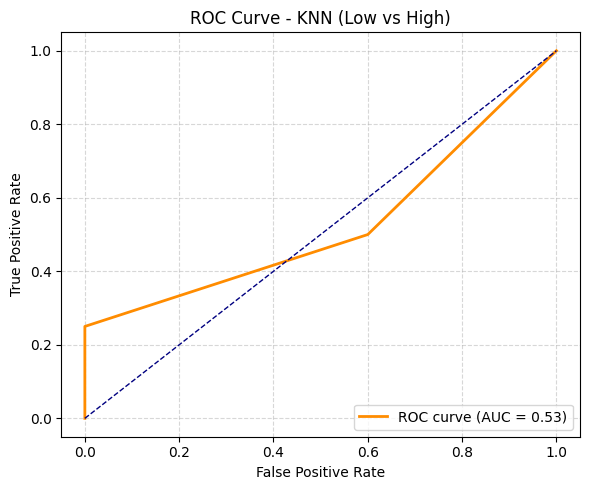

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

binary_df = merged_df[merged_df['Heart_Disease_Class'].isin(['Low', 'High'])].copy()

features = ['O3_Mean_norm', 'CO_Mean_norm', 'SO2_Mean_norm', 'NO2_Mean_norm', 'Pollution_Index']
X = binary_df[features]
y = binary_df['Heart_Disease_Class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - KNN (Low vs High)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### 🌳 Simple Decision Tree: Predicting Heart Disease Risk

As a preliminary step before applying more complex ensemble methods like Random Forest, a simple Decision Tree Classifier was implemented using only two features: **CO_Mean_norm** and **SO2_Mean_norm**.

This approach allows us to visualize the decision-making logic in a straightforward, interpretable way. By limiting the tree depth, we aim to gain insights into how these pollution-related features relate to heart disease class (High vs Low) without overfitting.

The resulting tree helps identify threshold splits in CO and SO2 levels that are associated with different heart disease risk classes, laying the groundwork for more advanced models in the next steps.


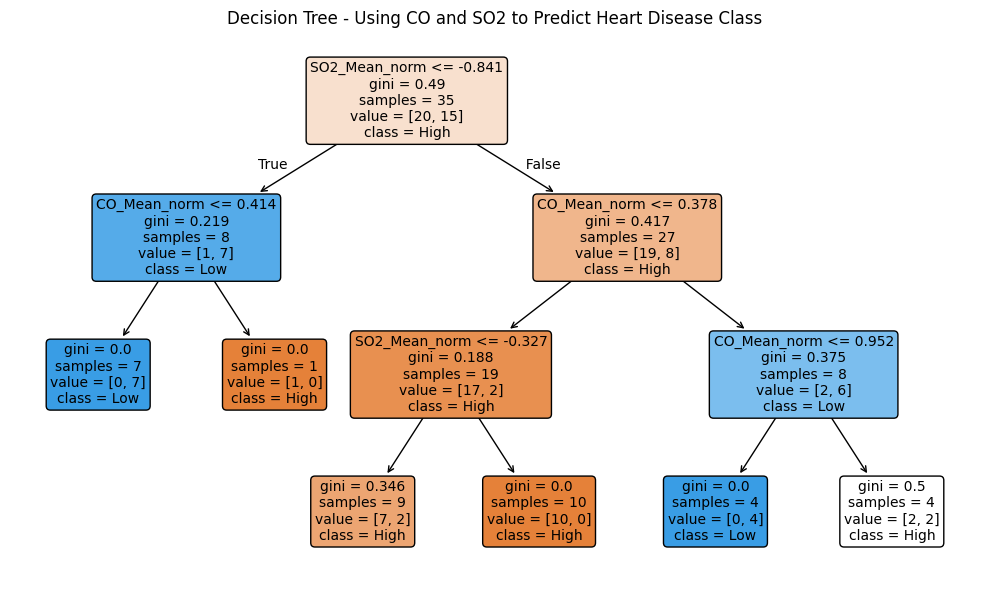

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

features = ['CO_Mean_norm', 'SO2_Mean_norm']
X = merged_df[features]
y = merged_df['Heart_Disease_Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

plt.figure(figsize=(10, 6))
plot_tree(
    dt_model,
    feature_names=features,
    class_names=dt_model.classes_,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree - Using CO and SO2 to Predict Heart Disease Class")
plt.tight_layout()
plt.show()

### 🌳 Feature Importance with Random Forest

In this section, we apply a **Random Forest Classifier** to evaluate the relative importance of air pollution indicators in predicting heart disease classes (Low vs High). Random Forest not only improves classification performance but also provides an interpretable measure of how much each feature contributes to the prediction task.

The feature importance plot below ranks the pollution-related variables by their predictive power, helping us identify which pollutants have the strongest association with cardiovascular health outcomes across states.


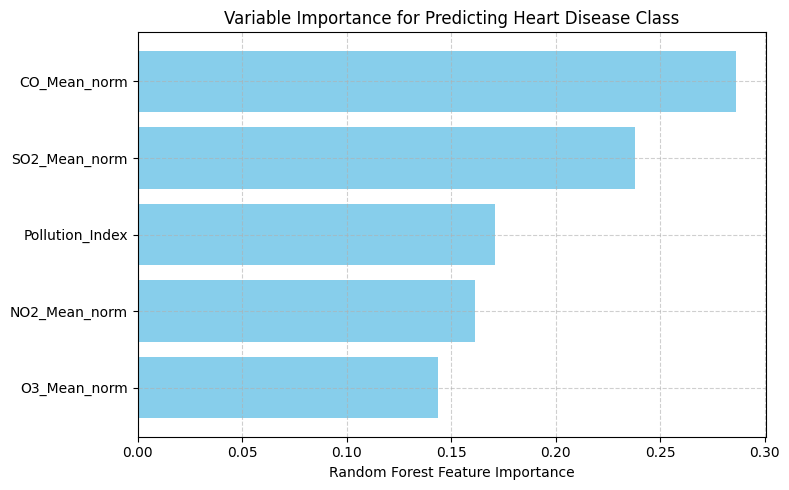

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

features = ['O3_Mean_norm', 'CO_Mean_norm', 'SO2_Mean_norm', 'NO2_Mean_norm', 'Pollution_Index']
X = merged_df[features]
y = merged_df['Heart_Disease_Class']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

rf_model = RandomForestClassifier(n_estimators=500, random_state=1)
rf_model.fit(X, y_encoded)

importances = rf_model.feature_importances_
sorted_idx = np.argsort(importances)

plt.figure(figsize=(8, 5))
plt.barh(np.array(features)[sorted_idx], importances[sorted_idx], color='skyblue')
plt.xlabel("Random Forest Feature Importance")
plt.title("Variable Importance for Predicting Heart Disease Class")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 🌲 Classification Using Random Forest (Low vs High)

In this section, a **Random Forest Classifier** is used to classify the heart disease risk level of each state into two categories: **Low** and **High**, based on their pollution levels. The model is trained using **CO Mean (normalized)** and **SO₂ Mean (normalized)** and **Pollution Index** and **NO₂ Mean (normalized)** and **O3 Mean (normalized)**

To ensure robustness despite the small dataset, we employed **Leave-One-Out Cross-Validation (LOOCV)**. This method allows us to make a prediction for each state by training the model on all remaining states, thereby simulating realistic generalization performance.

The resulting scatter plot below visualizes the predicted classes based on CO and SO₂ levels. It illustrates how the Random Forest algorithm distinguishes between low and high heart disease risk regions using learned decision boundaries in a nonlinear fashion.


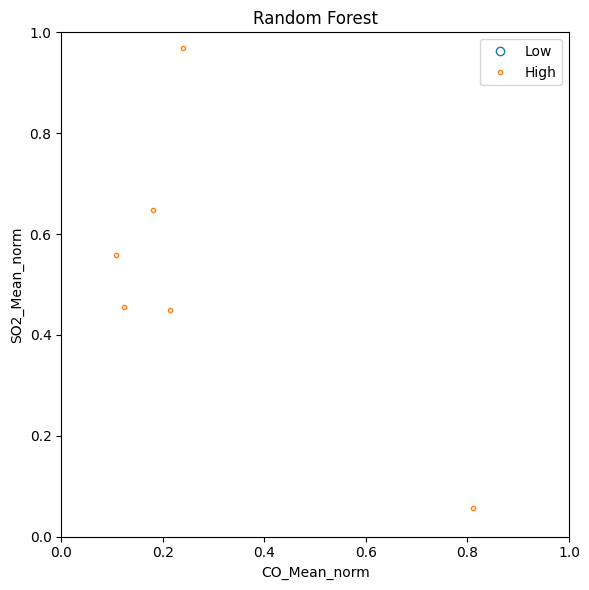

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

binary_df = merged_df[merged_df['Heart_Disease_Class'].isin(['Low', 'High'])].copy()
features = ['O3_Mean_norm', 'CO_Mean_norm', 'SO2_Mean_norm', 'NO2_Mean_norm', 'Pollution_Index']
X = binary_df[features]
y = binary_df['Heart_Disease_Class']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

loo = LeaveOneOut()
rf = RandomForestClassifier(n_estimators=500, random_state=1)
y_pred_encoded = cross_val_predict(rf, X, y_encoded, cv=loo)

y_pred = le.inverse_transform(y_pred_encoded)

predictions = binary_df[features].copy()
predictions['prediction'] = y_pred

fig, ax = plt.subplots(figsize=(6, 6))

predictions[predictions['prediction'] == 'Low'].plot(
    x='CO_Mean_norm', y='SO2_Mean_norm', style='o',
    markerfacecolor='none', markeredgecolor='C0', ax=ax, label='Low'
)

predictions[predictions['prediction'] == 'High'].plot(
    x='CO_Mean_norm', y='SO2_Mean_norm', style='.',
    markerfacecolor='none', markeredgecolor='C1', ax=ax, label='High'
)

ax.set_xlabel('CO_Mean_norm')
ax.set_ylabel('SO2_Mean_norm')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_title("Random Forest")
ax.legend(loc='best')

plt.tight_layout()
plt.show()

### 🧪 Model Evaluation: Confusion Matrix (Random Forest - Leave-One-Out)

To evaluate the predictive performance of the **Random Forest** model, we used the **Leave-One-Out Cross-Validation (LOOCV)** strategy.  
This approach provides a highly unbiased estimation by training the model on all but one instance and testing it on the remaining one — repeating this for every data point.

After obtaining the predictions using `cross_val_predict`, we constructed a **confusion matrix**, which visually summarizes the classification performance by comparing actual class labels with predicted ones.

- The matrix highlights how well the model distinguishes between the **'Low'** and **'High'** classes of heart disease prevalence.
- The diagonal values show **correct predictions**, while the off-diagonal cells reveal **misclassifications**.
- In this analysis, the model performed relatively well on the **'High'** class but struggled more with **'Low'**, potentially due to class imbalance or weaker signal.


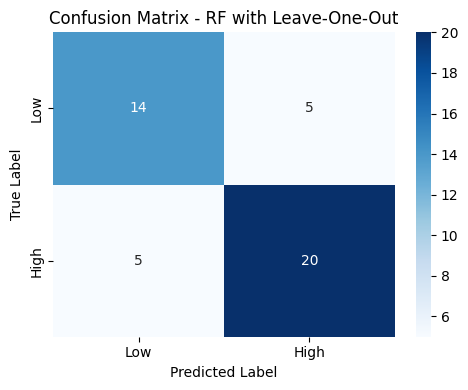

Accuracy: 0.77

Classification Report:
              precision    recall  f1-score   support

        High       0.80      0.80      0.80        25
         Low       0.74      0.74      0.74        19

    accuracy                           0.77        44
   macro avg       0.77      0.77      0.77        44
weighted avg       0.77      0.77      0.77        44



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder

import seaborn as sns

y_true = y.reset_index(drop=True)
y_pred_series = pd.Series(y_pred)

cm = confusion_matrix(y_true, y_pred_series, labels=['Low', 'High'])

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - RF with Leave-One-Out')
plt.tight_layout()
plt.show()

print(f"Accuracy: {accuracy_score(y_true, y_pred_series):.2f}\n")
print("Classification Report:")
print(classification_report(y_true, y_pred_series))


### 📉 ROC Curve & AUC (Random Forest - Leave-One-Out)

In addition to accuracy and classification report metrics, we plotted the **Receiver Operating Characteristic (ROC) Curve**, which is particularly useful for evaluating the model's ability to discriminate between the two classes across different threshold settings.

Using `cross_val_predict` with `predict_proba`, we extracted the predicted probabilities required for ROC analysis.

- The ROC curve illustrates the trade-off between the **true positive rate** (sensitivity) and the **false positive rate**.
- The **AUC (Area Under the Curve)** score was calculated to quantify the overall performance:  
  - An **AUC of 0.77** indicates **fair to good discriminative ability**, meaning the model has a 77% chance of ranking a randomly chosen positive instance higher than a negative one.

This analysis shows that Random Forests, especially when combined with LOOCV, offer a strong and interpretable method for predicting heart disease class from pollution indicators.

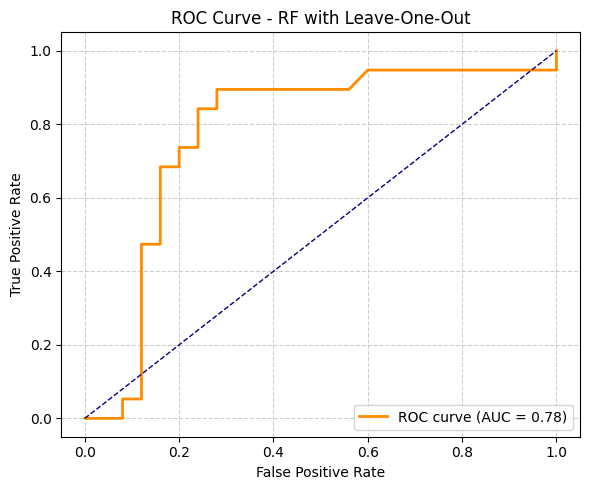

In [ ]:
le = LabelEncoder()
y_true_bin = le.fit_transform(y_true)
rf_probs = cross_val_predict(rf, X, y, cv=loo, method='predict_proba')[:, 1]

fpr, tpr, thresholds = roc_curve(y_true_bin, rf_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RF with Leave-One-Out')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 📌 XGBoost Model Application (with Leave-One-Out Cross-Validation)

In this section, the XGBoost algorithm was applied to classify heart disease risk as either **Low** or **High**, based on air pollution indicators (`CO_Mean_norm`, `SO2_Mean_norm`). To ensure robust and unbiased model evaluation despite the small sample size, **Leave-One-Out Cross-Validation (LOO-CV)** was utilized.

This method iteratively uses one observation as the test set and the remaining as the training set. The XGBoost classifier was configured with `logloss` as the evaluation metric and `n_estimators=25`. Both predicted class labels and predicted probabilities were generated to be used in further performance analysis.


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
df = merged_df[merged_df['Heart_Disease_Class'].isin(['Low', 'High'])].copy()
X = df[['CO_Mean_norm', 'SO2_Mean_norm']]
y = df['Heart_Disease_Class'].apply(lambda x: 1 if x == 'High' else 0)
loo = LeaveOneOut()
xgb = XGBClassifier(eval_metric='logloss', n_estimators=25)
y_pred = cross_val_predict(xgb, X, y, cv=loo, method='predict')
y_prob = cross_val_predict(xgb, X, y, cv=loo, method='predict_proba')[:, 1]

### 📊 Confusion Matrix – XGBoost (LOO)

The confusion matrix displays the model's classification performance across the two classes (Low and High). Diagonal values represent correctly classified instances, while off-diagonal values indicate misclassifications.

- **True Positives (High → High)**: 18  
- **True Negatives (Low → Low)**: 15  
- **False Positives (Low → High)**: 4  
- **False Negatives (High → Low)**: 7  

The resulting **accuracy score** was **0.75**, indicating relatively good performance considering the small dataset and class balance.


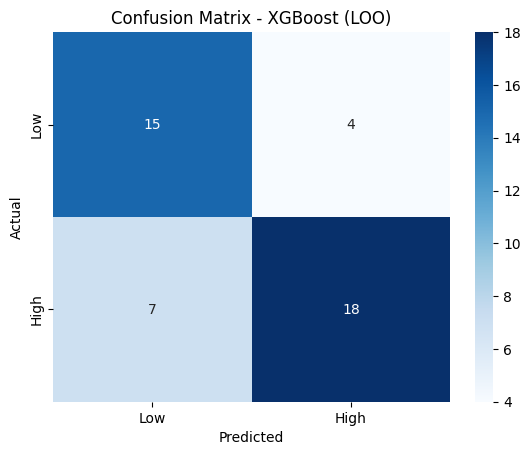

Accuracy: 0.75
              precision    recall  f1-score   support

         Low       0.68      0.79      0.73        19
        High       0.82      0.72      0.77        25

    accuracy                           0.75        44
   macro avg       0.75      0.75      0.75        44
weighted avg       0.76      0.75      0.75        44



In [ ]:
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
plt.title("Confusion Matrix - XGBoost (LOO)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
acc = accuracy_score(y, y_pred)
print(f"Accuracy: {acc:.2f}")
print(classification_report(y, y_pred, target_names=['Low', 'High']))

### 📈 ROC Curve – XGBoost (LOO)

The ROC curve illustrates the model’s ability to distinguish between the two heart disease classes across different threshold values. It plots the **True Positive Rate** (Recall) against the **False Positive Rate**.

- The **Area Under the Curve (AUC)** for the XGBoost model was calculated as **0.79**, indicating good class separability.
- AUC values close to 1.0 imply better performance, while a score of 0.5 would suggest random guessing.

The curve being significantly above the diagonal baseline confirms that the model performs better than random classification.


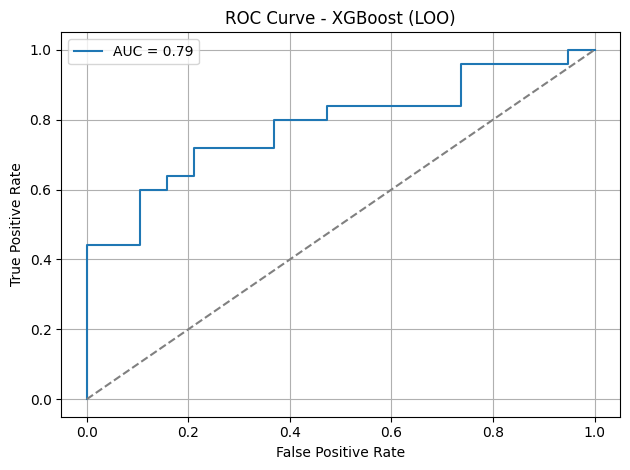

In [ ]:
fpr, tpr, _ = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost (LOO)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 🔄 Model Comparison: Summary of Predictive Techniques

| Model              | Type           | Metric           | AUC Score | Strengths                                          | Limitations                               |
|-------------------|----------------|------------------|-----------|---------------------------------------------------|-------------------------------------------|
| **Linear Regression** | Regression     | RMSE = 2.07<br>R² = 0.28 | –         | Simple and interpretable<br>Useful for trends     | Assumes linearity<br>Not suitable for classification |
| **KNN**            | Classification | Accuracy = 0.67  | 0.55      | Easy to implement<br>Works well on small datasets | Sensitive to noise & feature scaling      |
| **Random Forest**  | Classification | Accuracy = 0.77  | 0.78      | Captures complex patterns<br>Feature importance   | Lower interpretability<br>Can overfit without tuning |
| **XGBoost**        | Classification | Accuracy = 0.75  | 0.79      | High accuracy<br>Handles missing values<br>Efficient | More complex<br>Harder to interpret       |

---

### 📌 Insights:
- **XGBoost** achieved the highest AUC score (0.79) and strong accuracy (0.75), making it the most reliable model for classifying heart disease risk based on pollution indicators.
- **Random Forest** also performed well, with the second highest AUC (0.78) and the highest accuracy (0.77), suggesting very good class separation and balanced predictions.
- **KNN** achieved decent accuracy but a lower AUC, implying it may be biased toward one class (imbalanced performance).
- **Linear Regression**, gave insight into the continuous relationship between pollution and heart disease via R² and RMSE values RMSE = 2.07 and R² = 0.28.

> ✅ Overall, XGBoost was the most effective model for this binary classification problem.
